# Análisis menciones Barassi y Programa

La idea de este conjunto de funciones es explorar un poco más los tweets que hablan sobre Dario Barassi y su programa 100ArgentinosDicen. <br>
Vamos a hacer un analisis de sentimientos de los tweets<br>
Descargar las imagenes con más likes de cada conjunto de datos<br>
Hacer algunas gráficas<br>
y un par de wordclouds con las palabras más usadas


vamos a trabajar con dos sets de datos, uno para los tweets que mencionen a Dario Barassi y otro que mencionen al programa 100ArgentinosDicen

###### los datasets se extrajeron con las siguientes lineas en el entorno de consola de twint

*Aclaración: debido a que eran datasets bastante grandes por temas de continuidad de descarga tuve que dividirlos en dos archivos cada uno, esto no influye ya que los vamos a levantar y concatenar  

In [ ]:
#ejecutar en la consola
twint -s "100 argentinos dicen" -ho -o prueba100arg.csv --csv --count 

In [ ]:
#ejecutar en la consola
twint -s "Barassi -100 -argentinos -dicen" -ho -o mencionesBarassi.csv --csv --count 

### ahora si se viene el código

In [1]:
#primeras librerias
from datetime import date, datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
#leer archivos, como comente terminaron siendo 4 archivos por que no realice toda la descarga de continuo
df_m_pro_1 = pd.read_csv("prueba100arg.csv", delimiter='\t', dtype={'name': object},low_memory=False)
df_m_pro_2 = pd.read_csv("prueba100arg2.csv", delimiter='\t', dtype={'name': object},low_memory=False)
df_m_bar_1 = pd.read_csv("mencionesBarassi.csv", delimiter='\t', dtype={'name': object},low_memory=False)
df_m_bar_2 = pd.read_csv("mencionesBarassi2.csv", delimiter='\t', dtype={'name': object},low_memory=False)

In [3]:
#borrar columnas poco utiles (o vacias)
df_m_pro_1 = df_m_pro_1.drop(columns=["created_at","timezone","name","place","language","cashtags","retweet","near","geo","source","user_rt_id","retweet_id","user_rt","retweet_date","translate","trans_src","trans_dest"])
df_m_pro_2 = df_m_pro_2.drop(columns=["created_at","timezone","name","place","language","cashtags","retweet","near","geo","source","user_rt_id","retweet_id","user_rt","retweet_date","translate","trans_src","trans_dest"])
df_m_bar_1= df_m_bar_1.drop(columns=["created_at","timezone","name","place","language","cashtags","retweet","near","geo","source","user_rt_id","retweet_id","user_rt","retweet_date","translate","trans_src","trans_dest"])
df_m_bar_2=df_m_bar_2.drop(columns=["created_at","timezone","name","place","language","cashtags","retweet","near","geo","source","user_rt_id","retweet_id","user_rt","retweet_date","translate","trans_src","trans_dest"])

In [4]:
#funciones para modificar los formatos de tiempo y fecha
def formato_tiempo(tiempo):
    tiempo_out= pd.to_timedelta(tiempo)
    return tiempo_out

def formato_fecha(fecha):
    fecha_out= pd.to_datetime(fecha, infer_datetime_format=True)
    return fecha_out

In [5]:
#modificar formato fechas
df_m_pro_1["date"] = df_m_pro_1["date"].apply(formato_fecha)
df_m_pro_2["date"] = df_m_pro_2["date"].apply(formato_fecha)
df_m_bar_1["date"] = df_m_bar_1["date"].apply(formato_fecha)
df_m_bar_2["date"] = df_m_bar_2["date"].apply(formato_fecha)



In [6]:
#modificar formato tiempo
df_m_pro_1["time"] = df_m_pro_1["time"].apply(formato_fecha)
df_m_pro_2["time"] = df_m_pro_2["time"].apply(formato_fecha)
df_m_bar_1["time"] = df_m_bar_1["time"].apply(formato_fecha)
df_m_bar_2["time"] = df_m_bar_2["time"].apply(formato_fecha)



In [7]:
#juntar los dataframes
df_menciones_pro=pd.concat([df_m_pro_1,df_m_pro_2])
df_menciones_bar=pd.concat([df_m_bar_1,df_m_bar_2])

In [ ]:
#ver cantidad de rows de cada df
print(df_menciones_pro["id"].size)
print(df_menciones_bar["id"].size)

## analisis de sentimientos

In [8]:
#librerias para analisis de sentimientos
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline
from nltk.classify import NaiveBayesClassifier

In [21]:
#librerias para limpieza de texto
import string
import emoji
import re

In [16]:
#variables para quitar las palabras que no aportan 

stopwordList = stopwords.words("Spanish")
stopwordList = stopwordList + stopwords.words("English")
punctuationList = [string.punctuation]
stopwordsListfull = stopwordList + punctuationList + ['“','”','¡','¿',"''",'``','...','→','⬥','…']


In [17]:
#borra los emojis de los textos
def clean_tweets_emoji(Texto):
    allchars = [str for str in Texto]
    emoji_lista = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    emojiless = ' '.join([str for str in Texto.split() if not any(i in str for i in emoji_lista)])
    return emojiless

#se la aplica a la columna texto y la sobrescribe
#df

In [18]:
#funcion para limpiar los textos de los tweet
def clean_text(Texto):
    
    #re.sub("cadena a buscar", "con la que se reemplaza", cadena_leida)
    #variables del preprocesamiento
   
    caracteres_especiales = r'\W'
    caracter_individual = r'\s+[a-zA-Z]\s+'
    caracter_individual_inicio = r'\^[a-zA-Z]\s+'
    varios_espacios = r'\s+'
    prefijo_b = r'^b\s+'
    numeros = '[0-9]+'
    
    
    #limpieza
    Texto = re.sub(r'RT[\s]+', ' ', Texto)  #rts
    Texto = Texto.lower() 
    Texto = re.sub(r'@[a-zA-Z0-9-_.]+', '', Texto) #menciones
    Texto = re.sub(r'#[a-zA-Z0-9-_.]+', ' ', Texto) #hastags
    Texto = re.sub('\n|\r', '', Texto) #saltos de linea
    #urls
    Texto = re.sub(r'//[a-zA-Z0-9-_.]+', '', Texto)
    Texto = re.sub(r'https://[a-zA-Z0-9-_./]+', '', Texto)
    Texto = re.sub(r'https:[a-zA-Z0-9-_./]+', '', Texto)
    Texto = re.sub(r'www.[a-zA-Z0-9-_./]+', '', Texto)
    #acentos
    Texto = re.sub(r'[á|ä|â|à]', 'a', Texto)
    Texto = re.sub(r'[é|ê|è]', 'e', Texto)
    Texto = re.sub(r'[í|î|ì]', 'i', Texto)
    Texto = re.sub(r'[ó|ô|ò]', 'o', Texto)
    Texto = re.sub(r'[ú|û|ù|ü]', 'u', Texto)
    Texto = re.sub(caracteres_especiales, ' ', Texto)
    Texto = re.sub(caracter_individual, ' ', Texto)
    Texto = re.sub(caracter_individual_inicio, ' ', Texto) 
    Texto = re.sub(prefijo_b, '', Texto)
    Texto = re.sub(numeros, ' ', Texto)
    
    #tweet_procesado = re.sub(" q ", ' que ', tweet_procesado)
    #tweet_procesado = re.sub(" sr ", ' señor ', tweet_procesado)
    #tweet_procesado = re.sub(" x ", ' por ', tweet_procesado)
    #tweet_procesado = re.sub(" d ", ' de ', tweet_procesado)
    #tweet_procesado = re.sub(" xq ", ' porque ', tweet_procesado)
    varios_espacios = r'\s+'
    Texto = re.sub(varios_espacios, ' ', Texto, flags=re.I)
    return Texto

In [19]:
#tokeniza cada palabra que conforma un texto y revisa que no este en la lista de palabras inutiles
def tex_token(Texto):
    Texto_token = [palabra for palabra in word_tokenize(Texto) if palabra not in stopwordsListfull]
    return Texto_token

In [23]:
#tokeniza el texto y lo guarda en un diccionario donde cada palabra es una clave con valor 1 
#para luego procesar las palabras del diccionario y modificar sus valores en funcion del analisis de sentimientos
def construirBolsaDePalabras(Texto):
    diccionario={}
    for palabra in word_tokenize(Texto):
        if palabra not in stopwordsListfull:
            diccionario[palabra]=1
    return diccionario

In [13]:
#levantar sample para el analisis de datos
datos_excel = pd.read_excel(open('taggedTweets.xlsx','rb'))
datos_excel = pd.DataFrame(datos_excel)
sample = datos_excel.sample(len(datos_excel))
#sample

In [24]:
#generacion del robot de analisis
#variables donde vamos a guardar la cantidad de textos positivos y negativos 
rasgosNegativos = []
rasgosPositivos = []
rasgosNeutrales = []
# se lee el archivo sample, se limpia el texto y luego se coteja y guarda los sentimientos    
for indice_fila, fila in sample.iterrows():
    tweet_clean = clean_tweets_emoji(fila['Tweet'])
    tweet_clean = clean_text(tweet_clean)
    if fila['Sentimiento'] == 'pos':
        rasgosPositivos.append((construirBolsaDePalabras(tweet_clean),fila['Sentimiento']))
    elif fila['Sentimiento'] == 'neu':
        rasgosNeutrales.append((construirBolsaDePalabras(tweet_clean),fila['Sentimiento']))
    else:
        rasgosNegativos.append((construirBolsaDePalabras(tweet_clean),fila['Sentimiento']))

#se instancias la variables de cotejación del clasificador de sentimientos
divP=int(len(rasgosPositivos)*0.95)
divNeu=int(len(rasgosNeutrales)*0.95)
divNeg=int(len(rasgosNegativos)*0.95)
#clasificador de sentimientos
clasificadorSentimiento=NaiveBayesClassifier.train(rasgosPositivos[:divP]+rasgosNegativos[:divNeg]+rasgosNeutrales[:divNeu])

In [25]:
#funcion que aplica el robot a un input
def analisis_sent(Texto):
    bolsa = construirBolsaDePalabras(Texto)
    sent = clasificadorSentimiento.classify(bolsa)
    return sent

In [27]:
#limpiar tweets
df_menciones_pro["tweet_limpio"]=df_menciones_pro["tweet"].apply(clean_text)
df_menciones_bar["tweet_limpio"]=df_menciones_bar["tweet"].apply(clean_text)

In [28]:
df_menciones_pro["tweet_limpio"]=df_menciones_pro["tweet_limpio"].apply(clean_tweets_emoji)
df_menciones_bar["tweet_limpio"]=df_menciones_bar["tweet_limpio"].apply(clean_tweets_emoji)

In [29]:
#aplicar valoracion de analisis de sentimientos
df_menciones_pro["Sentimientos"]=df_menciones_pro["tweet_limpio"].apply(analisis_sent)
df_menciones_bar["Sentimientos"]=df_menciones_bar["tweet_limpio"].apply(analisis_sent)

In [30]:
#para ver como quedan los df
df_menciones_pro

,id,conversation_id,date,time,user_id,username,tweet,mentions,urls,photos,...,retweets_count,likes_count,hashtags,link,quote_url,video,thumbnail,reply_to,tweet_limpio,Sentimientos
0,1438501698960379913,1438501698960379913,2021-09-16,2021-09-23 10:55:05,3434472605,tvargentina_,Tarde 15/09 Telefe 14h40 Corta Por Lozano 6.6...,[],[],['https://pbs.twimg.com/media/E_aVofUUUAIT2Da....,...,0,0,[],https://twitter.com/tvargentina_/status/143850...,NaN,1,https://pbs.twimg.com/media/E_aVofUUUAIT2Da.jpg,[],tarde telefe h corta por lozano h dulce ambici...,pos
1,1438499614932418562,1438499614932418562,2021-09-16,2021-09-23 10:46:48,213383322,sergiorodo,Los 10 + vistos del miércoles! #BakeOffArgenti...,[],[],['https://pbs.twimg.com/media/E_aTxoBUcAEX4AP....,...,1,7,"['bakeoffargentina', 'drmilagro', 'zuleyha', '...",https://twitter.com/sergiorodo/status/14384996...,NaN,1,https://pbs.twimg.com/media/E_aTxoBUcAEX4AP.jpg,[],los vistos del miercoles,neg
2,1438499302565949444,1438499302565949444,2021-09-16,2021-09-23 10:45:34,1374026348419813377,lazaromartinok,"PROMEDIOS DE LA TARDE #Zuleyha 9,7 #100Argent...",[],[],['https://pbs.twimg.com/media/E_aTe6sVcAQ_JMq....,...,0,2,"['zuleyha', '100argentinosdicen', 'hercai', 'p...",https://twitter.com/LazaroMartinOK/status/1438...,NaN,1,https://pbs.twimg.com/media/E_aTe6sVcAQ_JMq.jpg,[],promedios de la tarde,neu
3,1438496587269955587,1438496587269955587,2021-09-16,2021-09-23 10:34:47,861509898,polimartinezzz,habría que estirar zuleyha hasta las 19hs para...,[],[],['https://pbs.twimg.com/media/E_aRACYUYAk8lWV....,...,0,1,[],https://twitter.com/PoliMartinezzz/status/1438...,NaN,1,https://pbs.twimg.com/media/E_aRACYUYAk8lWV.jpg,[],habria que estirar zuleyha hasta las hs para a...,pos
4,1438495951740604418,1438495951740604418,2021-09-16,2021-09-23 10:32:15,3434472605,tvargentina_,Líder: O 100 Argentinos Dicen marcou 8.9 de mé...,[],[],['https://pbs.twimg.com/media/E_aQGD4XoAIAR-p....,...,0,1,[],https://twitter.com/tvargentina_/status/143849...,NaN,1,https://pbs.twimg.com/media/E_aQGD4XoAIAR-p.jpg,[],lider argentinos dicen marcou de media nessa q...,neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45263,9261162187,9261162187,2010-02-17,2021-09-23 22:21:22,20513931,silviasantillan,Hola monchi!! que vuelva 100 argentinos dicen....,"[{'screen_name': 'monchibalestra', 'name': 'mo...",[],[],...,0,0,[],https://twitter.com/SilviaSantillan/status/926...,NaN,0,NaN,[],hola monchi que vuelva argentinos dicen,neu
45264,5459824923,5459669719,2009-11-05,2021-09-23 18:04:48,52816616,elenapaoloni,@capitanintriga de verdad? para mi Monchi es g...,[],[],[],...,0,0,[],https://twitter.com/elenapaoloni/status/545982...,NaN,0,NaN,[],de verdad para mi monchi es grandioso lo sigo ...,neg
45265,3773247690,3773247690,2009-09-05,2021-09-23 01:25:45,41342787,zabielita,El arte de mandar fruta. -- 100 Argentinos dic...,[],[],[],...,0,0,[],https://twitter.com/Zabielita/status/3773247690,NaN,0,NaN,[],el arte de mandar fruta argentinos dicen manda...,pos
45266,3773209108,3773209108,2009-09-05,2021-09-23 01:23:17,41342787,zabielita,El placer del intelecto jaaa. -- 100 Argentino...,[],[],[],...,0,0,[],https://twitter.com/Zabielita/status/3773209108,NaN,0,NaN,[],el placer del intelecto jaaa argentinos dicen ...,neg


## graficas de sentimientos

<AxesSubplot:xlabel='Sentimientos', ylabel='Cantidad de tweets'>

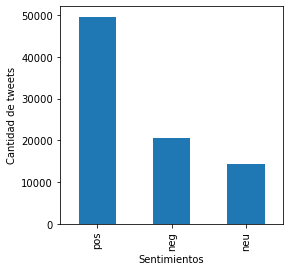

In [31]:
#grafica total de menciones del programa
df_menciones_pro["Sentimientos"].value_counts().plot.bar(figsize=(4, 4),xlabel="Sentimientos", ylabel="Cantidad de tweets", label="Sentimientos en tweets", legend=False)

<AxesSubplot:xlabel='Sentimientos', ylabel='Cantidad de tweets'>

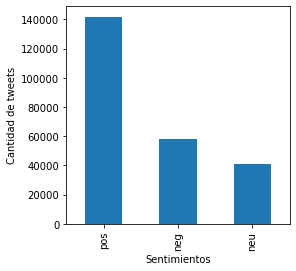

In [32]:
#grafica total de menciones de Barassi
df_menciones_bar["Sentimientos"].value_counts().plot.bar(figsize=(4, 4),xlabel="Sentimientos", ylabel="Cantidad de tweets", label="Sentimientos en tweets", legend=False)

### definir DFs imagenes

In [80]:
#vamos a definir df espeificos que solo contengan imagenes
df_menciones_bar_media=df_menciones_pro[(df_menciones_pro["photos"].str.startswith("[]") == False)]
df_menciones_pro_media=df_menciones_bar[(df_menciones_bar["photos"].str.startswith("[]") == False)]

######  graficas sentimientos imagenes

<AxesSubplot:xlabel='Sentimientos', ylabel='Cantidad de tweets'>

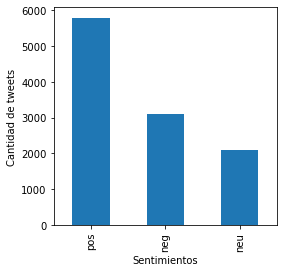

In [34]:
#
df_menciones_bar_media["Sentimientos"].value_counts().plot.bar(figsize=(4, 4),xlabel="Sentimientos", ylabel="Cantidad de tweets", label="Sentimientos en tweets", legend=False)

<AxesSubplot:xlabel='Sentimientos', ylabel='Cantidad de tweets'>

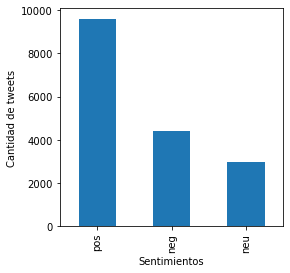

In [35]:
df_menciones_pro_media["Sentimientos"].value_counts().plot.bar(figsize=(4, 4),xlabel="Sentimientos", ylabel="Cantidad de tweets", label="Sentimientos en tweets", legend=False)

###  graficas imagenes

([<matplotlib.patches.Wedge at 0x1facf503370>,
 [Text(1.0500839371584993, 0.766370488028933, 'Tweets con imagenes :)'),
  Text(-0.8885325318540902, -0.6484673776196921, 'Tweets sin imagenes :(')])

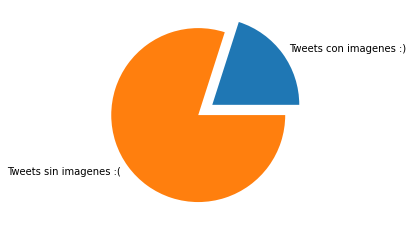

In [38]:
#grafica de proporcion de tweets con fotos en menciones del programa
conteo_pro= df_menciones_pro["id"].size
conteo_pro_media= df_menciones_pro_media["id"].size
conteo_pro_no_media=conteo_pro - conteo_pro_media
conteo_list_pro=[conteo_pro_media,conteo_pro_no_media]
leyendas=["Tweets con imagenes :)", "Tweets sin imagenes :("]
explosion = [0.2, 0]
plt.pie(conteo_list_pro, labels = leyendas, explode = explosion)


([<matplotlib.patches.Wedge at 0x1facf3480d0>,
 [Text(1.2866749036104321, 0.18565476675562506, 'Tweets con imagenes :)'),
  Text(-1.0887249276321325, -0.15709243123845207, 'Tweets sin imagenes :(')])

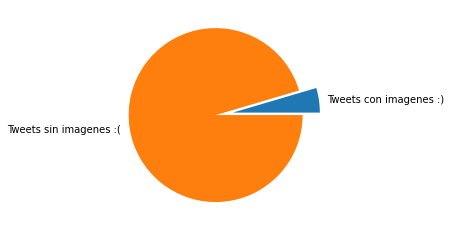

In [39]:
#grafica de proporcion de tweets con fotos en menciones de Barassi
conteo_bar= df_menciones_bar["id"].size
conteo_bar_media= df_menciones_bar_media["id"].size
conteo_bar_no_media=conteo_bar - conteo_bar_media
conteo_list_b=[conteo_bar_media,conteo_bar_no_media]
leyendas=["Tweets con imagenes :)", "Tweets sin imagenes :("]
explosion = [0.2, 0]
plt.pie(conteo_list_b, labels = leyendas, explode = explosion)

## descargar imagenes

In [40]:
#convertir los elementos de la columna fotos para poder iterar mejor en los elementos que tienen más de una foto
df_menciones_bar_media["photos"]=df_menciones_bar_media["photos"].apply(eval)
df_menciones_pro_media["photos"]=df_menciones_pro_media["photos"].apply(eval)
#no preocuparse por el mensaje de warning que aparece

<ipython-input-40-b979940dd2ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_menciones_bar_media["photos"]=df_menciones_bar_media["photos"].apply(eval)
<ipython-input-40-b979940dd2ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_menciones_pro_media["photos"]=df_menciones_pro_media["photos"].apply(eval)


In [ ]:
#funcion para contar la cantidad de fotos de cada tweet, la hice más que nada para ver si se modifico correctamente el tipo de dato
def len_photos (photo):
    len_photo=len(photo)
    return len_photo
df_menciones_bar_media["len_photos"]=df_menciones_bar_media["photos"].apply(len_photos)
df_menciones_pro_media["len_photos"]=df_menciones_pro_media["photos"].apply(len_photos)

In [ ]:
#df_menciones_bar_media["photos"]

In [ ]:
#df_menciones_pro_media["photos"]

# Descarga de imágenes

In [ ]:
#funcion de prueba para revisar que extensiones de imagenes hay en el dataframe pueden ser jpg,png e incluso gif (en este caso no hay gifs)
def is_jpg (photo):
    for p in photo:
        x=re.search("....$",p)
        x=x.group(0)
    return x
df_menciones_bar_media["photos"].apply(is_jpg).value_counts()
#si da error la ejecución es por que en el dataframe hay valores que no machean con la busqueda por lo que hay rows deberian limpiarse(no me preocupa ahora mismo)

In [59]:
#librerias para esto
import requests
import re

In [75]:
#funcion descargar imagenes
def descargar_img_t (ids,photos): #recibe dos parametros columna id(que contiene el id del tweet) y photos(que son listas con urls donde estan las imagenes)
    ruta="D:\FotosBarassi2" #se define la ruta de la carpeta donde se guadaran las fotos
    for p in photos: #iterar en cada array de fotos
        z=re.search("....$",p) #extrae la extensión del archivo de la url, en este punto se guarda un objeto re.match 
        z=z.group(0) #extrae la extensión del objeto re.match 
        y=photos.index(p) #extra el lugar de la url dentro del array de links de fotos de un tweet
        ruta_completa=ruta +"\\"+ str(ids) + "_" + str(y) + z   #crea la ruta completa sumando la ruta, una barra, el id del tweet para poder identificar de donde sale la foto, el indice de la foto (por que puede haber más de una foto por tweet) y la extension
        imagen=requests.get(p).content #se conecta a la url
        with open(ruta_completa, "wb") as handler: #crea el archivo de la imagen y lo abre
            handler.write(imagen) #guarda la foto que descargó


esta linea es la que aplica la funcion de arriba y la que descargará las imagenes:<br>
primero se define el df que se quiere utilizar,<br>
luego las dos columnas del df
luego se aplica un lambda para separar las dos colunas y mandarlas separadas a la funcion



In [78]:
#funcion para aplicar la descarga
df_menciones_pro_media_top100[["id","photos"]].apply(lambda x: descargar_img_t(*x), axis=1)

5591      None
36194     None
33299     None
109629    None
52099     None
          ... 
94890     None
18564     None
86677     None
10508     None
9168      None
Length: 100, dtype: object

In [ ]:
#por si se para la descarga:
#revisar cual fue la ultima foto descargada, copiar el id del nombre 
#crear un nuevo df cuyo id sea menor a al del nombre de la foto
#la descarga se aplica de arriba a abajo del df 
#arriba estan los tweets más nuevos 
df_menciones_pro_media_2 =df_menciones_pro_media[df_menciones_pro_media["id"] < 1366825092458704896]
df_menciones_pro_media_2

In [47]:
#aca queria revisar que tantos tweets habia con más de 50 likes y descargar todas estas imagenes
df_menciones_pro_media_filter=df_menciones_pro_media[df_menciones_pro_media["likes_count"] >=50]
df_menciones_bar_media_filter=df_menciones_bar_media[df_menciones_bar_media["likes_count"] >=50]

In [48]:
print(df_menciones_pro_media_filter["id"].size)
print(df_menciones_bar_media_filter["id"].size)

1459
990


In [50]:
#al final termine descargando solo las 100 fotos con más likes  
#cree los dataframes y use la funcion de descarga que muestro arriba
df_menciones_bar_media_top100=df_menciones_bar_media.sort_values("likes_count", ascending=False).head(100)
df_menciones_pro_media_top100=df_menciones_pro_media.sort_values("likes_count", ascending=False).head(100)

In [77]:
df_menciones_pro_media_top100

,id,conversation_id,date,time,user_id,username,tweet,mentions,urls,photos,...,retweets_count,likes_count,hashtags,link,quote_url,video,thumbnail,reply_to,tweet_limpio,Sentimientos
5591,1390018883390685185,1390018883390685185,2021-05-05,2021-09-23 16:01:41,3388072487,julianmendozza,De que lado de la mecha te encontrás? Rt Guid...,[],[],[https://pbs.twimg.com/media/E0pWzYaWYAo8jZe.j...,...,1313,84689,[],https://twitter.com/julianmendozza/status/1390...,NaN,1,https://pbs.twimg.com/media/E0pWzYaWYAo8jZe.jpg,[],de que lado de la mecha te encontras rt guido ...,pos
36194,1347732306862223365,1347732306862223365,2021-01-08,2021-09-23 23:29:56,201115273,bedefecchi,Lo que le escribió Barassi a la novia por su c...,[],[],[https://pbs.twimg.com/media/ErQbYGoW8AALSTc.j...,...,6876,68486,[],https://twitter.com/bedefecchi/status/13477323...,NaN,1,https://pbs.twimg.com/media/ErQbYGoW8AALSTc.jpg,[],lo que le escribio barassi la novia por su cum...,neg
33299,1427671620307636240,1427671620307636240,2021-08-17,2021-09-23 13:40:13,1242810644,luupstein,Bueno creo que me sigue el pibe que fue al pro...,[],[],[https://pbs.twimg.com/media/E9AbxUjWEAIDBmg.jpg],...,656,41263,[],https://twitter.com/luupstein/status/142767162...,NaN,1,https://pbs.twimg.com/media/E9AbxUjWEAIDBmg.jpg,[],bueno creo que me sigue el pibe que fue al pro...,neu
109629,1427671620307636240,1427671620307636240,2021-08-17,2021-09-23 13:40:13,1242810644,luupstein,Bueno creo que me sigue el pibe que fue al pro...,[],[],[https://pbs.twimg.com/media/E9AbxUjWEAIDBmg.jpg],...,655,41262,[],https://twitter.com/luupstein/status/142767162...,NaN,1,https://pbs.twimg.com/media/E9AbxUjWEAIDBmg.jpg,[],bueno creo que me sigue el pibe que fue al pro...,neu
52099,1421311134955671557,1421311134955671557,2021-07-31,2021-09-23 00:25:55,2850552243,berrettasofi,el gordo barassi https://t.co/wm4zBF3vkW,[],[],[https://pbs.twimg.com/media/E7mC8FBWEAUgXyk.j...,...,938,30573,[],https://twitter.com/berrettasofi/status/142131...,NaN,1,https://pbs.twimg.com/media/E7mC8FBWEAUgXyk.jpg,[],el gordo barassi,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94890,1433985219544166403,1433936505559523335,2021-09-03,2021-09-23 23:48:13,1405305882917978112,kondatodopiola,@becerravocals ya existía un Barassi en USA h...,[],[],[https://pbs.twimg.com/media/E-aJ9PGWYAI1y7D.jpg],...,14,1239,[],https://twitter.com/kondatodopiola/status/1433...,NaN,1,https://pbs.twimg.com/media/E-aJ9PGWYAI1y7D.jpg,"[{'screen_name': 'becerravocals', 'name': 'yaz...",ya existia un barassi en usa,neu
18564,1433985219544166403,1433936505559523335,2021-09-03,2021-09-23 23:48:13,1405305882917978112,kondatodopiola,@becerravocals ya existía un Barassi en USA h...,[],[],[https://pbs.twimg.com/media/E-aJ9PGWYAI1y7D.jpg],...,14,1239,[],https://twitter.com/kondatodopiola/status/1433...,NaN,1,https://pbs.twimg.com/media/E-aJ9PGWYAI1y7D.jpg,"[{'screen_name': 'becerravocals', 'name': 'yaz...",ya existia un barassi en usa,neu
86677,1437472341815173122,1437472341815173122,2021-09-13,2021-09-23 14:44:47,157493684,faqucazon_,"#MatchGame queremos a barassi, fuera rada! QUE...",[],[],[https://pbs.twimg.com/media/E_LtedmXMAEfyr5.jpg],...,195,1225,"['matchgame', '100argentinosdicen']",https://twitter.com/FaquCazon_/status/14374723...,NaN,1,https://pbs.twimg.com/media/E_LtedmXMAEfyr5.jpg,[],queremos barassi fuera rada queremos barassi f...,neu
10508,1437472341815173122,1437472341815173122,2021-09-13,2021-09-23 14:44:47,157493684,faqucazon_,"#MatchGame queremos a barassi, fuera rada! QUE...",[],[],[https://pbs.twimg.com/media/E_LtedmXMAEfyr5.jpg],...,195,1224,"['matchgame', '100argentinosdicen']",https://twitter.com/FaquCazon_/status/14374723...,NaN,1,https://pbs.twimg.com/media/E_LtedmXMAEfyr5.jpg,[],queremos barassi fuera rada queremos barassi f...,neu


## word clouds

In [85]:
#librerias para las wordclouds
import stylecloud
#https://github.com/minimaxir/stylecloud

from wordcloud import WordCloud, ImageColorGenerator #más ejemplos de wordclouds https://github.com/amueller/word_cloud/tree/master/examples
from PIL import Image #para importar imagenes
from scipy.ndimage import gaussian_gradient_magnitude

In [94]:
#hacer la word cloud de menc
string_menciones_pro = ' '.join(df_menciones_pro["tweet_limpio"])#crear un texto con todo lo que contiene la columna tweet limpio que creamos al principio 
style= stylecloud.gen_stylecloud(text= string_menciones_pro, #ingresar el texto desde una varible o un texto plano con comillas ""
                             #file_path='Discurso.txt', #ingresa el texto desde un archivo (puede ser un csv cuyas columnas sean textos)
                          icon_name="fab fa-twitter", #nombre el icono desde la lista de font awesome
                          
                          colors='#1b95e0', #color de las letras, podemos poner un listado de coloreshtml ['#ecf0f1', '#3498db', '#e74c3c']
                          background_color="#0e2439", #color del fondo
                          output_name='mencionespro.png', #nombre del archivo de salida
                          collocations=False, #reconoce vocablos de dos palabras
                          custom_stopwords=stopwordList #aplica limpieza de palabras sencillas
                         )

In [95]:
string_menciones_bar = ' '.join(df_menciones_bar.tweet_limpio)
style= stylecloud.gen_stylecloud(text= string_menciones_bar, #ingresar el texto desde una varible o un texto plano con comillas ""
                             #file_path='Discurso.txt', #ingresa el texto desde un archivo (puede ser un csv cuyas columnas sean textos)
                          icon_name="fab fa-twitter", #nombre el icono desde la lista de font awesome
                          
                          colors='#1b95e0', #color de las letras, podemos poner un listado de coloreshtml ['#ecf0f1', '#3498db', '#e74c3c']
                          background_color="#0e2439", #color del fondo
                          output_name='mencionesbar-negativos.png', #nombre del archivo de salida
                          collocations=False, #reconoce vocablos de dos palabras
                          custom_stopwords=stopwordList #aplica limpieza de palabras sencillas
                         )